# 딥러닝 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [36]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [37]:
df = fdr.DataReader('003490','2020-01-01', '2022-05-27') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [38]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,18479,18511,17993,18058,303459,-0.022835
2020-01-03,18155,18252,17668,17701,572272,-0.019770
2020-01-06,17409,17571,16858,17183,690224,-0.029264
2020-01-07,17182,17604,17117,17410,388103,0.013211
2020-01-08,17150,17312,16826,17053,676198,-0.020505
...,...,...,...,...,...,...
2022-05-23,28950,28950,28600,28750,1001628,-0.001736
2022-05-24,28850,29150,28550,28650,1024749,-0.003478
2022-05-25,28550,28700,28400,28500,988866,-0.005236


In [39]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246., 738337.]),
 <a list of 11 Text major ticklabel objects>)

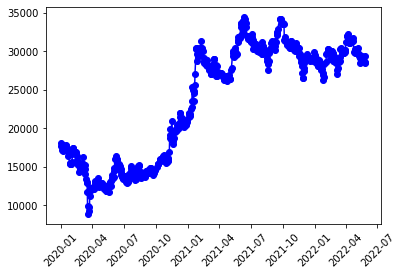

In [40]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [25]:
import os
import sys
import urllib.request
client_id = "8y4FUmFdq2Ojofq_vHAA"
client_secret = "dC9XGv5tQR"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-05-27\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"KoreaAir_N\",\"keywords\":[\"국제유가\",\"입국제한\",\"항공주\"]}, {\"groupName\":\"KoreaAir_P\",\"keywords\":[\"대한항공\",\"아시아나항공\",\"진에어\",\"제주항공\",\"티웨이항공\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [41]:
search_count_json = json.loads(search_count)

In [42]:
search_count_json

{'endDate': '2022-05-27',
 'results': [{'data': [{'period': '2020-01-01', 'ratio': 0.34072},
    {'period': '2020-01-02', 'ratio': 0.48353},
    {'period': '2020-01-03', 'ratio': 1.40077},
    {'period': '2020-01-04', 'ratio': 1.18459},
    {'period': '2020-01-05', 'ratio': 0.68043},
    {'period': '2020-01-06', 'ratio': 1.99974},
    {'period': '2020-01-07', 'ratio': 7.81728},
    {'period': '2020-01-08', 'ratio': 3.37707},
    {'period': '2020-01-09', 'ratio': 4.12253},
    {'period': '2020-01-10', 'ratio': 1.21889},
    {'period': '2020-01-11', 'ratio': 0.76916},
    {'period': '2020-01-12', 'ratio': 0.43846},
    {'period': '2020-01-13', 'ratio': 0.81832},
    {'period': '2020-01-14', 'ratio': 0.9487},
    {'period': '2020-01-15', 'ratio': 0.84387},
    {'period': '2020-01-16', 'ratio': 0.81532},
    {'period': '2020-01-17', 'ratio': 0.72501},
    {'period': '2020-01-18', 'ratio': 0.44756},
    {'period': '2020-01-19', 'ratio': 0.22044},
    {'period': '2020-01-20', 'ratio': 0.4932

## 1-3. 데이터 전처리 및 Merge하기

In [43]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [44]:
df_all = df

In [45]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.6982597774796164

In [46]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

0.018551362996579557

In [47]:
#df_all[df_all["Count"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

In [48]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
dtype: bool

In [49]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1
0,2020-01-02,18479,18511,17993,18058,303459,-0.022835,0.48353,20.59947
1,2020-01-03,18155,18252,17668,17701,572272,-0.019770,1.40077,18.61524
2,2020-01-06,17409,17571,16858,17183,690224,-0.029264,1.99974,21.48967
3,2020-01-07,17182,17604,17117,17410,388103,0.013211,7.81728,23.67063
4,2020-01-08,17150,17312,16826,17053,676198,-0.020505,3.37707,22.77317
...,...,...,...,...,...,...,...,...,...
590,2022-05-23,28950,28950,28600,28750,1001628,-0.001736,3.09569,14.54663
591,2022-05-24,28850,29150,28550,28650,1024749,-0.003478,3.53499,13.76403
592,2022-05-25,28550,28700,28400,28500,988866,-0.005236,3.40119,13.47180
593,2022-05-26,28550,28800,28450,28600,953524,0.003509,3.33124,13.15262


## 1-4. Feature Selection

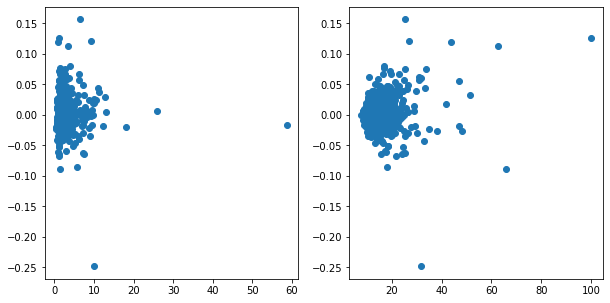

In [50]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Key_Count1"], df_all["Change"])


# 2. Define Model

In [51]:
input_size = 2 # x0의 dimension = feature의 개수 = 2
hidden_size = 10 # 임의로 지정
rnn = torch.nn.RNN(2, 10) # rnn = torch.nn.RNN(input_size, hidden_size)
input = torch.randn(1, 5, 2) # (batchsize, seq, input_size)
output, _ = rnn(input) # output (b, s, hidden_size)

In [52]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layer=1):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers = num_layer ,batch_first=True)
        #self.relu = torch.nn.ReLU()
        self.linear_classifier = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(0))
        #x = self.relu(x)
        x = self.linear_classifier(x[:,-1])
        return x

# 3. Define the loss function and the optimizer

In [53]:
input_dim = 2
hidden_dim = 10
sequence_size = 5
output_dim = 1
layer_size = 1

learning_rate = 0.001
model = RNNModel(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [54]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0','Scaled_Key_Count1']] = scaler.fit_transform(df[['Key_Count0','Key_Count1']])

In [56]:
df_all = df

In [57]:
df_all.head()

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1,Scaled_Key_Count0,Scaled_Key_Count1
0,2020-01-02,18479,18511,17993,18058,303459,-0.022835,0.48353,20.59947,0.000000,0.140646
1,2020-01-03,18155,18252,17668,17701,572272,-0.019770,1.40077,18.61524,0.015730,0.119170
2,2020-01-06,17409,17571,16858,17183,690224,-0.029264,1.99974,21.48967,0.026002,0.150280
3,2020-01-07,17182,17604,17117,17410,388103,0.013211,7.81728,23.67063,0.125771,0.173885
4,2020-01-08,17150,17312,16826,17053,676198,-0.020505,3.37707,22.77317,0.049623,0.164172


In [58]:
'''
x_scaled = df_all[['Scaled_Key_Count0','Scaled_Key_Count1']].to_numpy()
y_scaled = df_all["Change"].to_numpy()

train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)
'''

'\nx_scaled = df_all[[\'Scaled_Key_Count0\',\'Scaled_Key_Count1\']].to_numpy()\ny_scaled = df_all["Change"].to_numpy()\n\ntrain_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)\n'

In [59]:
seq_x = []
seq_y = []

feature_list = ['Scaled_Key_Count0','Scaled_Key_Count1']
df_all[feature_list][0:5]
x = df_all[feature_list][1:6]
y = df_all["Change"][6]
#print(y)

In [60]:
s_idx = 0
e_idx = len(df_all)
date_interval = 1
num_days = 4
y_days = 5

In [61]:
for idx in range(s_idx, e_idx, date_interval):
    if idx == 590:
        break
    x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
    y = df_all.loc[y_days+idx]["Change"].tolist()

    seq_x.append(x) if len(x) == 5 else None
    seq_y.append(y) if len(x) == 5 else None
    #x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
    #y = df_all.loc[idx:idx+num_days]["Change"].sum().tolist()

    #seq_x.append(x) if len(x) == 5 else None
    #seq_y.append(y) if len(x) == 5 else None

In [62]:
train_x, test_x, train_y, test_y = train_test_split(seq_x, seq_y, test_size=0.2)

In [63]:
train_x[0]

[[0.02463693453074082, 0.14956476263578034],
 [0.026560775929928136, 0.11264870303291628],
 [0.022777404107190445, 0.09051398140776461],
 [0.01407844429863479, 0.11701114209384085],
 [0.0370446654302953, 0.12535483306773615]]

In [64]:
best_model = None
num_epoch = 500
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<BarContainer object of 500 artists>

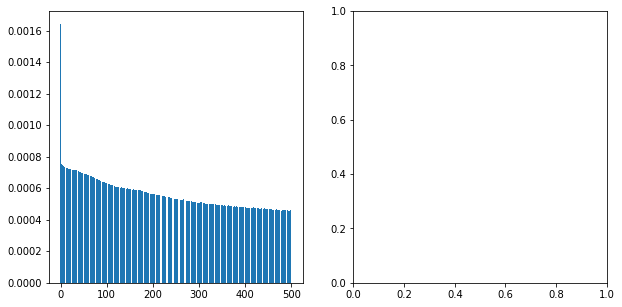

In [65]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(range(num_epoch), loss_epoch)
#ax2.scatter(train_x[-1], train_y)
#x = np.linspace(0,1,100)
#linear_weight = model.linear_classifier.weight.detach().numpy()
#lienar_bias = model.linear_classifier.bias.detach().numpy()
#y = linear_weight*x+lienar_bias
#y = y.reshape((100))
#ax2.plot(x, y, '-r', label='y='+str(linear_weight[-1][-1])+'x+'+str(lienar_bias[-1]))
#ax2.legend(loc='upper left')

In [66]:
loss_epoch

[0.001642796832150404,
 0.0007512152462589043,
 0.0007513710653089143,
 0.0007494160902519273,
 0.0007468805668779275,
 0.0007442810005733997,
 0.0007418037153152755,
 0.0007395091637133274,
 0.0007374072860122984,
 0.000735489067541806,
 0.000733739293869039,
 0.0007321422267433121,
 0.0007306831291482009,
 0.0007293484754474975,
 0.0007281253872282795,
 0.0007270005941735477,
 0.0007259601368896531,
 0.0007249901587083842,
 0.000724078222243538,
 0.0007232147401317649,
 0.0007223928323943044,
 0.0007216077478486961,
 0.00072085624939865,
 0.000720136401166141,
 0.0007194476459147395,
 0.0007187901266879123,
 0.0007181626963817983,
 0.0007175580691889092,
 0.0007169625059045841,
 0.0007163633869401517,
 0.0007157520077731139,
 0.0007151186171167367,
 0.0007144521844802134,
 0.0007137456097162348,
 0.0007129938545889776,
 0.0007121887700445753,
 0.000711319490194519,
 0.0007103735318540069,
 0.0007093378577428344,
 0.000708200002229041,
 0.0007069503921073155,
 0.0007055859945975866,
 

# 6. Evaluation

In [67]:
x_predicted = []
for idx in range(len(test_x)):
  predicted = model(torch.tensor(test_x[idx]).float())
  x_predicted.append(predicted.detach())
x_pred_np = np.array(x_predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


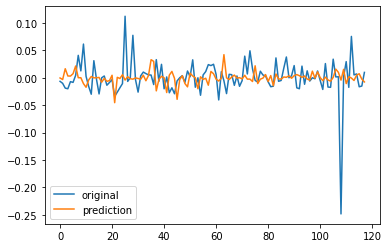

In [68]:
plt.plot(test_y)
plt.plot(x_pred_np)
plt.legend(['original', 'prediction'])
plt.show()

# 7. Prediction

In [69]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [100]:
raw_input = [[0.2,20], [0.2, 25], [0.2, 25], [0.2, 25], [0.3, 100]]
scaled_input = []
for a_day in raw_input:
    key_count = np.array(a_day)
    scaled = scaler.transform(key_count.reshape(1,-1)).tolist()[0]
    scaled_input.append(scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na

In [101]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [102]:
print("검색량이"+str(raw_input)+"일때 주가는", str(predicted.item()*100) )

검색량이[[0.2, 20], [0.2, 25], [0.2, 25], [0.2, 25], [0.3, 100]]일때 주가는 2.4250997230410576
